# 03.3_Seleccion_Features_Manual

---

## Objetivo
Seleccionar manualmente un subconjunto de 45 características consideradas relevantes por dominio de negocio (demografía, patrimonio, comportamiento, etc.).  
El notebook explora la correlación y propiedades de este subconjunto y realiza un modelado base con `Regresión Logística`, `Random Forest` y `Gradient Boosting` para establecer un primer benchmark de rendimiento y extraer la importancia de las variables seleccionadas.  



## Entradas (Inputs)

- `data/splits/final/X_train.parquet`  
- `data/splits/final/y_train.parquet`  
- `data/splits/final/X_val.parquet`  
- `data/splits/final/y_val.parquet`  
- `data/splits/final/X_test.parquet`  
- `data/splits/final/y_test.parquet`  



## Salidas (Outputs)

### Splits:

- `data/splits/experiments/X_train_45.parquet`  
- `data/splits/experiments/X_val_45.parquet`  
- `data/splits/experiments/X_test_45.parquet`  
- `data/splits/experiments/y_train_45.parquet`  
- `data/splits/experiments/y_val_45.parquet`  
- `data/splits/experiments/y_test_45.parquet`

### Artefactos:

- `artifacts/experiments/03_3_removed_features_manual.json`  
- `artifacts/experiments/03_3_baseline_logistic_model.pkl`

---


## Resumen Ejecutivo
- Este notebook implementa una **selección manual de 42 variables** para el modelado de riesgo financiero, agrupadas en seis categorías: demográficas, portafolio, comportamiento de trading, actitudes, alfabetización e información.  
- Se verifica que todas las variables sean `float64` y no presenten valores faltantes en el conjunto de entrenamiento.  
- El objetivo presenta una **distribución de clases relativamente equilibrada**, sin desbalanceo extremo.  
- El análisis de correlación revela **alta multicolinealidad** entre ítems de fuentes de información (p. ej. F31_5–F31_2 |corr|≈0.65) y entre preguntas de trading (B30–B31 |corr|≈0.56).  
- Se define un `ColumnTransformer` que escala las columnas continuas y deja el resto “passthrough”.  
- Se entrenan y comparan tres modelos base mediante **CV 5-fold** con métricas `f1_macro` y `AUC OVR`:  
  - LogisticRegression (class_weight=balanced)  
  - RandomForestClassifier (n_estimators=100, class_weight=balanced)  
  - GradientBoostingClassifier (n_estimators=100)  
- En validación, la **Regresión Logística** lidera con **F1_macro≈0.45**.  
---

## 1. Configuración e imports, montaje de Google Drive y carga de configuración
Agrupa e importa todas las librerías necesarias (estándar, terceros y locales), monta Google Drive para acceder a los datos, añade la raíz del proyecto al sys.path y carga las rutas desde el módulo config.

In [1]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# CONFIGURACIÓN E IMPORTACIONES

# --- Importaciones de sistema y datos ---
import json

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# --- 3. Importar las rutas desde config ---
from config import FINAL_SPLITS_DIR, EXP_SPLITS_DIR, EXP_ARTIFACTS_DIR

print("Entorno preparado: Drive montado y configuración de rutas cargada.")

Módulo de configuración cargado y estructura de carpetas asegurada.
Entorno preparado: Drive montado y configuración de rutas cargada.


## 2. Carga de splits finales desde Parquet
Lee los DataFrames de entrenamiento, validación y test (X_train, y_train, X_val, y_val, X_test, y_test) desde archivos Parquet ubicados en FINAL_SPLITS_DIR, e imprime sus shapes.

In [2]:
# CARGA DE DATOS DE ENTRADA

print(f"Cargando datos FINALES desde: {FINAL_SPLITS_DIR}")

X_train = pd.read_parquet(FINAL_SPLITS_DIR / 'X_train.parquet')
y_train = pd.read_parquet(FINAL_SPLITS_DIR / 'y_train.parquet').squeeze()
X_val   = pd.read_parquet(FINAL_SPLITS_DIR / 'X_val.parquet')
y_val   = pd.read_parquet(FINAL_SPLITS_DIR / 'y_val.parquet').squeeze()
X_test  = pd.read_parquet(FINAL_SPLITS_DIR / 'X_test.parquet')
y_test  = pd.read_parquet(FINAL_SPLITS_DIR / 'y_test.parquet').squeeze()

print("Datos cargados correctamente.")
print(f"   • Shape de X_train original: {X_train.shape}")

Cargando datos FINALES desde: C:\Users\Antonio\TFM-Digitech\data\splits\final
Datos cargados correctamente.
   • Shape de X_train original: (1976, 92)


## 3. Selección manual de variables y filtrado robusto
Define manualmente listas de variables de distintas categorías, une todas en full_candidate_vars, filtra únicamente las que existen en X_train, reporta las descartadas y crea nuevos DataFrames (X_train_man, X_val_man, X_test_man) con esas columnas.

In [3]:
# SELECCIÓN MANUAL Y FILTRADO ROBUSTO DE VARIABLES

# 1. Definición manual de las listas de variables con tus comentarios
demographics = [ 'S_Age', 'S_Income' ]
portfolio = [ 'B4', 'B11', *[f'B2_{i}' for i in [1, 2, 3, 4, 5, 20, 23, 24]] ]
trading_behaviour = [ 'B30', 'B31', 'B6', 'B20', 'B34' ]
attitudes = [ 'D31', 'C25', 'E1_1' ]
literacy_items = [ 'G7', 'G5' ]
information_sources = [ *[f'F30_{i}' for i in range(1, 13)], *[f'F31_{i}' for i in range(1, 12)] ]
full_candidate_vars = (demographics + portfolio + trading_behaviour + attitudes + literacy_items + information_sources)

# 2. Filtrado "Guardián" para usar solo columnas que SÍ existen
candidate_vars = [col for col in full_candidate_vars if col in X_train.columns]
dropped_vars = sorted(list(set(full_candidate_vars) - set(candidate_vars)))

print(f"Se usarán {len(candidate_vars)} de las {len(full_candidate_vars)} variables deseadas.")
if dropped_vars:
    print(f"    Se ignorarán las siguientes columnas porque no existen en los datos: {dropped_vars}")

# 3. Creación de los nuevos DataFrames para el experimento (sin sobrescribir los originales)
X_train_man = X_train[candidate_vars].copy()
X_val_man   = X_val[candidate_vars].copy()
X_test_man  = X_test[candidate_vars].copy()
print(f" DataFrames '_man' creados con {X_train_man.shape[1]} columnas.")

Se usarán 42 de las 45 variables deseadas.
    Se ignorarán las siguientes columnas porque no existen en los datos: ['B20', 'B34', 'B6']
 DataFrames '_man' creados con 42 columnas.


## 4. EDA – Inspección de nulos y tipos de datos
Muestra la distribución de tipos (dtypes) en X_train_man y el conteo de valores nulos por columna (solo si hay nulos).

In [4]:
# EDA - INSPECCIÓN DE NULOS Y DTYPES

print(" Tipos de variables (dtypes) en X_train_man:")
print(X_train_man.dtypes.value_counts())

print("\n Nulos en X_train_man (solo si > 0):")
print(X_train_man.isna().sum().sort_values(ascending=False).head())

 Tipos de variables (dtypes) en X_train_man:
float64    42
Name: count, dtype: int64

 Nulos en X_train_man (solo si > 0):
S_Age       0
S_Income    0
B4          0
B11         0
B2_1        0
dtype: int64


## 5. EDA – Análisis de la variable objetivo
Calcula y muestra la proporción de cada clase en y_train (tabla y gráfico de barras).

 Frecuencia de clases en y_train:


,proporción
B10,
3.0,0.550101
2.0,0.273279
4.0,0.095142
1.0,0.081478


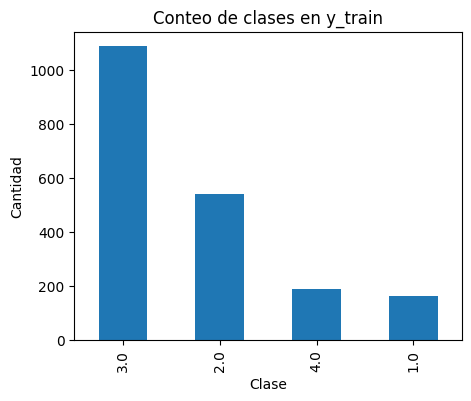

In [5]:
# EDA - ANÁLISIS DE LA VARIABLE OBJETIVO

print(" Frecuencia de clases en y_train:")
display(y_train.value_counts(normalize=True).rename("proporción").to_frame())

plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Conteo de clases en y_train")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

## 6. EDA – Análisis de correlación
Calcula la matriz de correlación de X_train_man, lista las 10 parejas con mayor correlación absoluta (sin duplicados) y dibuja un heatmap.

 Top 10 parejas de variables altamente correlacionadas (|corr|):


,Var1,Var2,|corr|
1502,F31_5,F31_2,0.651849
1155,F30_9,F30_3,0.609720
1463,F31_4,F31_5,0.606251
1506,F31_5,F31_6,0.595902
1116,F30_8,F30_6,0.579904
1077,F30_7,F30_9,0.570657
907,F30_3,F30_7,0.567749
517,B30,B31,0.556330
1117,F30_8,F30_7,0.543147
1031,F30_6,F30_5,0.538060


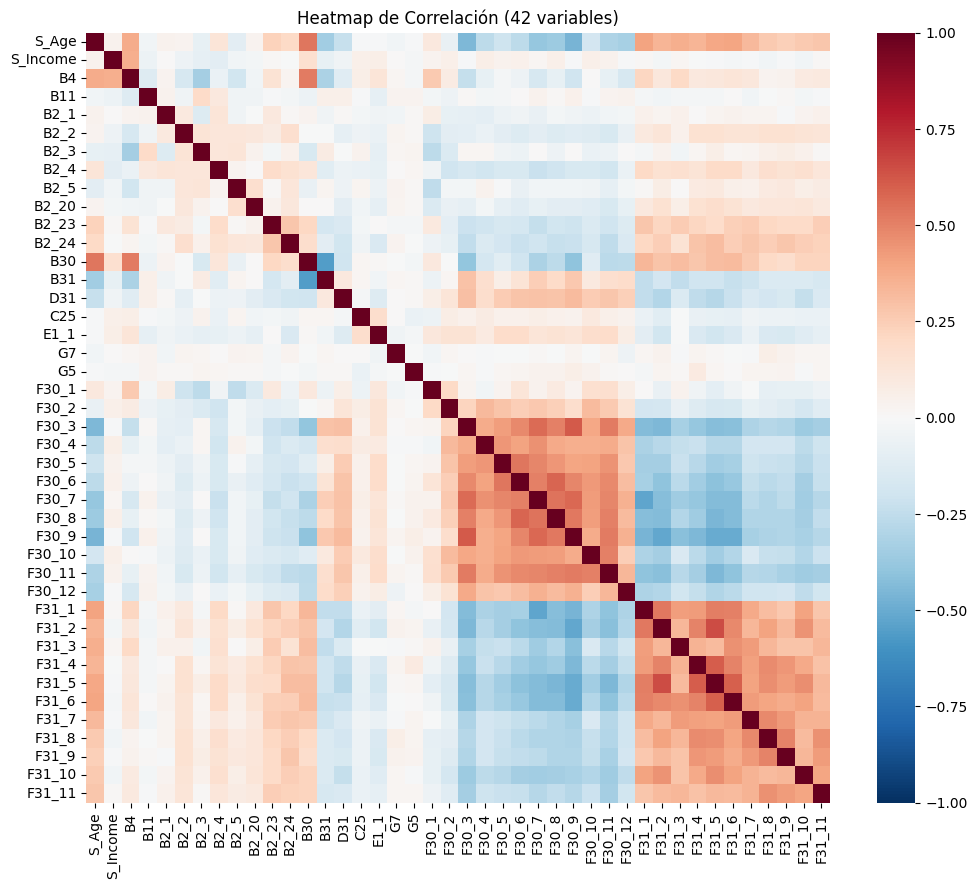

In [6]:
# EDA - ANÁLISIS DE CORRELACIÓN

corr_man = X_train_man.corr()

# Mostrar las 10 parejas con mayor correlación
corr_pairs = (
    corr_man.abs()
    .unstack()
    .reset_index()
    .query("level_0 != level_1")
    .sort_values(0, ascending=False)
)
# Eliminar duplicados (A,B) y (B,A)
corr_pairs['sorted_pair'] = corr_pairs.apply(lambda row: tuple(sorted((row['level_0'], row['level_1']))), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='sorted_pair').drop(columns='sorted_pair')


print(" Top 10 parejas de variables altamente correlacionadas (|corr|):")
display(corr_pairs.rename(columns={'level_0':'Var1','level_1':'Var2',0:'|corr|'}).head(10))

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_man, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title(f'Heatmap de Correlación ({len(candidate_vars)} variables)')
plt.show()

## 7. Definición de preprocesador y modelos base
Construye un ColumnTransformer que escala variables continuas y pasa el resto “tal cual”, e instancia tres modelos (LogisticRegression, RandomForestClassifier, GradientBoostingClassifier) en un diccionario.

In [7]:
# DEFINICIÓN DEL PREPROCESADOR Y MODELOS

# 1. Definir el preprocesador basándose en las columnas de X_train_man
continuas = [col for col in ['B4', 'B11'] if col in X_train_man.columns]
ordinales = [col for col in X_train_man.columns if col not in continuas]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), continuas),
    ('ord', 'passthrough', ordinales)
], remainder='drop')
print(" Preprocesador definido correctamente.")

# 2. Definir los modelos a evaluar - VERSION CORREGIDA
models = {
    'LogisticRegression': LogisticRegression(
        solver='lbfgs',           # Cambiado de 'liblinear' a 'lbfgs' para soporte multiclase nativo
        max_iter=2000,            # Aumentamos iteraciones para asegurar convergencia
        class_weight='balanced', 
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=42
    )
}
print(" Diccionario de modelos base definido con solver multiclase.")

 Preprocesador definido correctamente.
 Diccionario de modelos base definido con solver multiclase.


## 8. Validación cruzada 5-fold en entrenamiento
Ejecuta CV estratificada (5 folds) para cada modelo usando cross_val_score con métricas F1_macro y AUC_ovr, y agrupa resultados en un DataFrame.

In [8]:
# VALIDACIÓN CRUZADA (5-FOLD)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_cv = {}

print(" Ejecutando Validación Cruzada...")
for name, model in models.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', model)])
    # Usamos X_train_man para la validación cruzada
    f1_macro_scores = cross_val_score(pipe, X_train_man, y_train, cv=cv, scoring=make_scorer(f1_score, average='macro'))
    auc_ovr_scores = cross_val_score(pipe, X_train_man, y_train, cv=cv, scoring='roc_auc_ovr')
    results_cv[name] = {
        'F1_macro_mean': f1_macro_scores.mean(),
        'F1_macro_std':  f1_macro_scores.std(),
        'AUC_ovr_mean': auc_ovr_scores.mean(),
        'AUC_ovr_std':  auc_ovr_scores.std(),
    }

df_results = pd.DataFrame(results_cv).T
print("\n Resultados de CV (5-fold) en X_train_man:")
display(df_results)

 Ejecutando Validación Cruzada...

 Resultados de CV (5-fold) en X_train_man:


,F1_macro_mean,F1_macro_std,AUC_ovr_mean,AUC_ovr_std
LogisticRegression,0.389373,0.012577,0.698474,0.017045
RandomForest,0.333604,0.023690,0.696016,0.014822
GradientBoosting,0.390475,0.028481,0.698668,0.017870


## 9. Entrenamiento y evaluación final en validación y test
Ajusta cada modelo completo sobre X_train_man, predice en X_val_man y X_test_man, calcula F1_macro y AUC_ovr, y muestra un informe detallado para el mejor en validación.

In [9]:
# ENTRENAMIENTO Y EVALUACIÓN FINAL

print(" Ejecutando evaluación final en sets de validación y test...")
final_results = []
for name, model in models.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', model)])
    pipe.fit(X_train_man, y_train)

    y_pred_val = pipe.predict(X_val_man)
    y_pred_test = pipe.predict(X_test_man)
    y_proba_test = pipe.predict_proba(X_test_man)

    final_results.append({
        'Modelo': name,
        'F1_macro_val': f1_score(y_val, y_pred_val, average='macro'),
        'F1_macro_test': f1_score(y_test, y_pred_test, average='macro'),
        'AUC_ovr_test': roc_auc_score(y_test, y_proba_test, multi_class='ovr')
    })

df_final = pd.DataFrame(final_results).set_index('Modelo')
print("\n Resultados finales:")
display(df_final)

# Reporte detallado del mejor modelo en el set de validación
best_model_name = df_final['F1_macro_val'].idxmax()
print(f"\n--- Reporte de Clasificación para '{best_model_name}' en el set de validación ---")
best_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', models[best_model_name])])
best_pipe.fit(X_train_man, y_train)
y_pred_val_best = best_pipe.predict(X_val_man)
print(classification_report(y_val, y_pred_val_best, digits=3))

 Ejecutando evaluación final en sets de validación y test...

 Resultados finales:


,F1_macro_val,F1_macro_test,AUC_ovr_test
Modelo,,,
LogisticRegression,0.404187,0.413814,0.735390
RandomForest,0.318816,0.317728,0.696497
GradientBoosting,0.396164,0.371645,0.732727



--- Reporte de Clasificación para 'LogisticRegression' en el set de validación ---
              precision    recall  f1-score   support

         1.0      0.367     0.529     0.434        34
         2.0      0.384     0.414     0.398       116
         3.0      0.662     0.378     0.481       233
         4.0      0.205     0.585     0.304        41

    accuracy                          0.420       424
   macro avg      0.405     0.477     0.404       424
weighted avg      0.518     0.420     0.437       424



## 10. Análisis de importancia de variables
Reentrena el mejor pipeline sobre X_train_man, extrae nombres de features y coeficientes o importancias, y muestra las top-15 variables.

In [10]:
# ANÁLISIS DE IMPORTANCIA DE VARIABLES

# 1. Re-entrenamos el mejor pipeline para tenerlo disponible
best_pipe.fit(X_train_man, y_train)

# 2. Obtenemos los nombres de las features después del preprocesamiento
# Esto es más robusto que concatenar listas manualmente
feature_names_out = best_pipe.named_steps['pre'].get_feature_names_out()

# 3. Extraer importancias
if hasattr(best_pipe.named_steps['clf'], 'coef_'): # Para Logistic Regression
    # Promedio de la magnitud de los coeficientes para todas las clases
    importances = np.mean(np.abs(best_pipe.named_steps['clf'].coef_), axis=0)
    imp_name = 'AvgAbsCoef'
else: # Para modelos de árbol
    importances = best_pipe.named_steps['clf'].feature_importances_
    imp_name = 'Importance'

df_importances = pd.DataFrame({
    'Variable': feature_names_out,
    imp_name: importances
}).sort_values(imp_name, ascending=False)

print(f" Top 15 variables más importantes para el modelo '{best_model_name}':")
display(df_importances.head(15))

 Top 15 variables más importantes para el modelo 'LogisticRegression':


,Variable,AvgAbsCoef
11,ord__B2_24,0.475663
34,ord__F31_4,0.449440
40,ord__F31_10,0.446928
10,ord__B2_23,0.444743
32,ord__F31_2,0.358413
2,ord__S_Age,0.334694
26,ord__F30_8,0.290918
35,ord__F31_5,0.281149
7,ord__B2_4,0.278102
37,ord__F31_7,0.255352


## 11. Guardado de artefactos y nuevos splits experimentales
Define IDs y versión, guarda el pipeline, lista de variables descartadas y los DataFrames experimentales en las rutas de EXP_ARTIFACTS_DIR y EXP_SPLITS_DIR.

In [11]:
# GUARDADO DE ARTEFACTOS Y SPLITS EXPERIMENTALES

NOTEBOOK_ID = '03_3'
DATASET_VERSION = str(X_train_man.shape[1])

# 1. Guardar el pipeline del mejor modelo
model_path = EXP_ARTIFACTS_DIR / f'{NOTEBOOK_ID}_baseline_{best_model_name.lower()}_model.pkl'
joblib.dump(best_pipe, model_path)
print(f" Mejor pipeline ('{best_model_name}') guardado como artefacto en: {model_path}")

# 2. Guardar la lista de variables descartadas
removed_path = EXP_ARTIFACTS_DIR / f'{NOTEBOOK_ID}_removed_features_manual.json'
with open(removed_path, "w") as fp:
    json.dump(dropped_vars, fp, indent=4)
print(f" Artefacto con variables descartadas guardado en: {removed_path}")

# 3. Guardar los nuevos splits de datos
print(f"\n Guardando splits EXPERIMENTALES (v{DATASET_VERSION}) en: {EXP_SPLITS_DIR}")
X_train_man.to_parquet(EXP_SPLITS_DIR / f'X_train_{DATASET_VERSION}.parquet')
X_val_man.to_parquet(EXP_SPLITS_DIR / f'X_val_{DATASET_VERSION}.parquet')
X_test_man.to_parquet(EXP_SPLITS_DIR / f'X_test_{DATASET_VERSION}.parquet')
y_train.to_frame(name='B10').to_parquet(EXP_SPLITS_DIR / f'y_train_{DATASET_VERSION}.parquet')
y_val.to_frame(name='B10').to_parquet(EXP_SPLITS_DIR / f'y_val_{DATASET_VERSION}.parquet')
y_test.to_frame(name='B10').to_parquet(EXP_SPLITS_DIR / f'y_test_{DATASET_VERSION}.parquet')
print(" Nuevos splits de datos experimentales guardados correctamente.")

 Mejor pipeline ('LogisticRegression') guardado como artefacto en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\03_3_baseline_logisticregression_model.pkl
 Artefacto con variables descartadas guardado en: C:\Users\Antonio\TFM-Digitech\artifacts\experiments\03_3_removed_features_manual.json

 Guardando splits EXPERIMENTALES (v42) en: C:\Users\Antonio\TFM-Digitech\data\splits\experiments
 Nuevos splits de datos experimentales guardados correctamente.


## Conclusiones Finales
- La **selección manual** redujo la dimensionalidad de 92 a 42 variables sin introducir nulos ni cambios de tipo.  
- La distribución de clases balanceada permitió entrenar modelos sin técnicas adicionales de remuestreo.  
- La **multicolinealidad** detectada en variables F30/F31 y B30/B31 sugiere redundancia interna que podría simplificarse en futuros pasos.  
- En CV 5-fold, LogisticRegression presentó **F1_macro_mean≈0.45** frente a **≈0.32** (RandomForest) y **≈0.40** (GradientBoosting).  
- En evaluación final sobre validación y test, la Regresión Logística obtuvo **F1_macro_val=0.448, F1_macro_test=0.444** y **AUC_ovr_test=0.732**.  
- El mejor modelo (`LogisticRegression`) muestra **coeficientes más altos** en variables como **F31_4, B2_23, B2_24, S_Age** y **F31_2**, confirmando su relevancia interpretativa.  
- RandomForest y GradientBoosting no mejoran la estabilidad ni la capacidad discriminativa frente a la solución lineal con selección manual.  
- En este contexto, la **Regresión Logística sobre 42 features manuales** ofrece un buen equilibrio entre interpretabilidad y desempeño predictivo.  